<a href="https://colab.research.google.com/github/honestycitra/dl_hw_test/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conditional GAN**

Source: https://github.com/DSC-UI-SRIN/Introduction-to-GAN/blob/master/1%20-%20Fundamental%20of%20GANs/CGAN.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import numpy as np
import math
import os

cuda = True if torch.cuda.is_available() else False

## **1. Prepare dataset**

Dataset used : MNIST

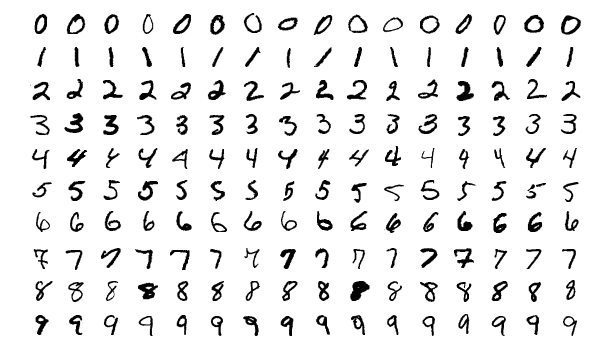

In [2]:
# Configure data loader
batch_size = 64

img_size = 28
channels = 1
img_shape = (channels, img_size, img_size)

os.makedirs("data/mnist", exist_ok=True)

transforms = transforms.Compose([transforms.Resize(img_size), 
                              transforms.ToTensor(), 
                              transforms.Normalize([0.5], [0.5])]
                             )

mnist_dataset = datasets.MNIST("data/mnist",
                               train=True,
                               download=True,
                               transform=transforms)

dataloader = torch.utils.data.DataLoader(mnist_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



### **Sample dataset to visualize**

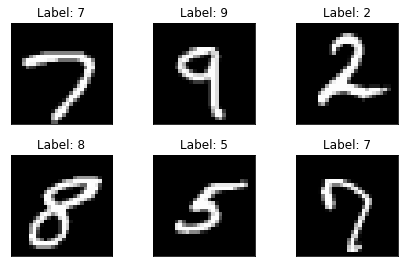

In [3]:
import matplotlib.pyplot as plt

examples = enumerate(dataloader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

plt.show()

## **2. Build model**

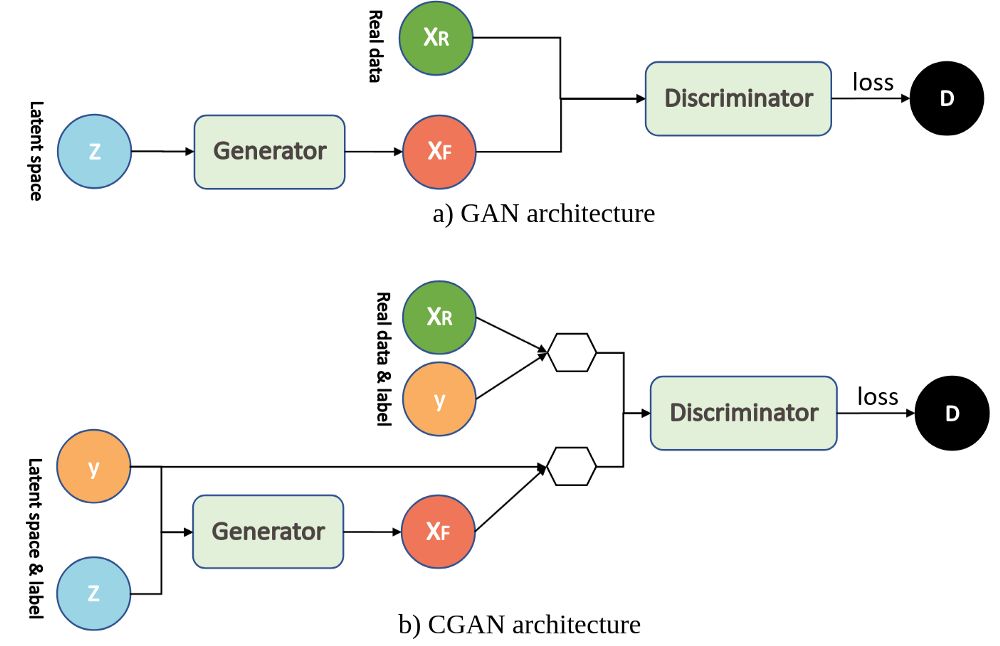

### **a. Generator**

In [4]:
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

### **b. Discriminator**

In [5]:
class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [6]:
z_dim = 100
n_classes = len(mnist_dataset.classes)

# Initialize generator and discriminator
generator = Generator(n_classes=n_classes, 
                      latent_dim=z_dim)

discriminator = Discriminator(n_classes=n_classes)

# Loss functions
adversarial_loss = torch.nn.MSELoss()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [7]:
print(generator, discriminator)

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
) Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_featu

### 3. Train the model

In [8]:
# Optimizers
lr = 0.0002
b1 = 0.5
b2 = 0.999
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [9]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, z_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

# **CGAN Loss Function**

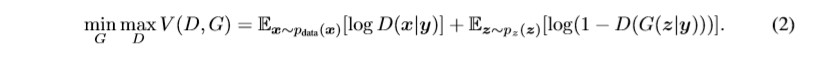

In [10]:
os.makedirs("images", exist_ok=True)
n_epochs = 200

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, z_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % 300 == 0:
            sample_image(n_row=10, batches_done=batches_done)

Streaming output truncated to the last 5000 lines.
[Epoch 194/200] [Batch 628/938] [D loss: 0.200999] [G loss: 0.324858]
[Epoch 194/200] [Batch 629/938] [D loss: 0.229198] [G loss: 0.416739]
[Epoch 194/200] [Batch 630/938] [D loss: 0.226218] [G loss: 0.357204]
[Epoch 194/200] [Batch 631/938] [D loss: 0.206650] [G loss: 0.326567]
[Epoch 194/200] [Batch 632/938] [D loss: 0.204080] [G loss: 0.334943]
[Epoch 194/200] [Batch 633/938] [D loss: 0.202054] [G loss: 0.465545]
[Epoch 194/200] [Batch 634/938] [D loss: 0.207131] [G loss: 0.355834]
[Epoch 194/200] [Batch 635/938] [D loss: 0.219258] [G loss: 0.317749]
[Epoch 194/200] [Batch 636/938] [D loss: 0.233464] [G loss: 0.344491]
[Epoch 194/200] [Batch 637/938] [D loss: 0.238967] [G loss: 0.349881]
[Epoch 194/200] [Batch 638/938] [D loss: 0.216454] [G loss: 0.318079]
[Epoch 194/200] [Batch 639/938] [D loss: 0.246519] [G loss: 0.362258]
[Epoch 194/200] [Batch 640/938] [D loss: 0.225156] [G loss: 0.338142]
[Epoch 194/200] [Batch 641/938] [D loss